In [1]:
%pip install kaggle

In [2]:
%pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=c2e15a6827c68c39e3418a4889d3c1451ba18ebe9b6db20f09cd3afe209332e9
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
!kaggle datasets download -d shitovvladimir/a-blood-atlas-of-covid-19-combat-preprocessed

Dataset URL: https://www.kaggle.com/datasets/shitovvladimir/a-blood-atlas-of-covid-19-combat-preprocessed
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.46G/1.46G [00:21<00:00, 59.8MB/s]
100% 1.46G/1.46G [00:21<00:00, 71.2MB/s]


In [ ]:
!unzip a-blood-atlas-of-covid-19-combat-preprocessed.zip -d covid19_dataset

Archive:  a-blood-atlas-of-covid-19-combat-preprocessed.zip
  inflating: covid19_dataset/combat_processed.h5ad  


In [ ]:
# Импорт библиотек
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'scanpy'

In [ ]:
# Загрузка данных
adata = sc.read_h5ad('/content/covid19_dataset/combat_processed.h5ad')

In [ ]:
# Предобработка
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# Фильтрация генов по дисперсии
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

In [ ]:
# Выбор целевой переменной
y = adata.obs['DiseaseClassification']
y_cat = pd.Categorical(y)
y_codes = y_cat.codes
num_classes = len(np.unique(y_codes))

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 783704 × 2000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_cont

In [ ]:
# Признаки
X = adata.X

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y_codes, test_size=0.2, random_state=42)

In [ ]:
# Масштабирование
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Подготовка меток
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [ ]:
# Построение модели
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Обучение модели с EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

In [ ]:
# Сокращение числа генов до 500
sc.pp.highly_variable_genes(adata, n_top_genes=500)
adata = adata[:, adata.var.highly_variable]

# Альтернативно: использование PCA
# sc.tl.pca(adata, n_comps=50)
# X = adata.obsm['X_pca']

# Преобразование матрицы в плотный формат
X = adata.X.toarray()

# Освобождение памяти
del adata
gc.collect()

# Выбор целевой переменной
y = pd.Categorical(adata.obs['disease']).codes
num_classes = len(np.unique(y))

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Освобождение памяти
del X_train, X_test
gc.collect()

# Подготовка меток
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Построение модели
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели с уменьшенным размером батча
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_cat,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Оценка модели
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat)
print(f'Точность на тестовых данных: {test_acc}')

# Графики обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label='Точность на валидационной выборке')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на обучающей выборке')
plt.plot(history.history['val_loss'], label='Потери на валидационной выборке')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=d59efc1c7328d96eb89ec11f7d4686e9adb086f9335721dafd77433c54e0b650
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Точность на тестовых данных: 0.6704


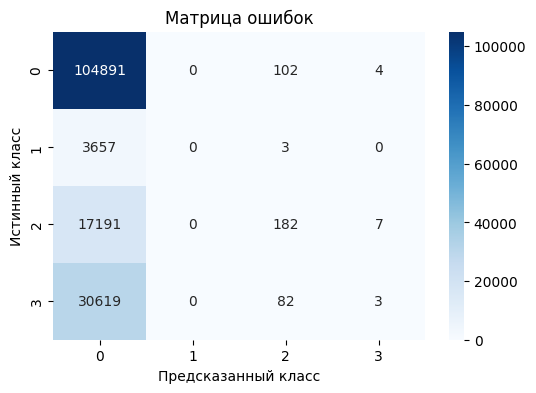

Отчет классификации:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80    104997
           1       0.00      0.00      0.00      3660
           2       0.49      0.01      0.02     17380
           3       0.21      0.00      0.00     30704

    accuracy                           0.67    156741
   macro avg       0.34      0.25      0.21    156741
weighted avg       0.55      0.67      0.54    156741



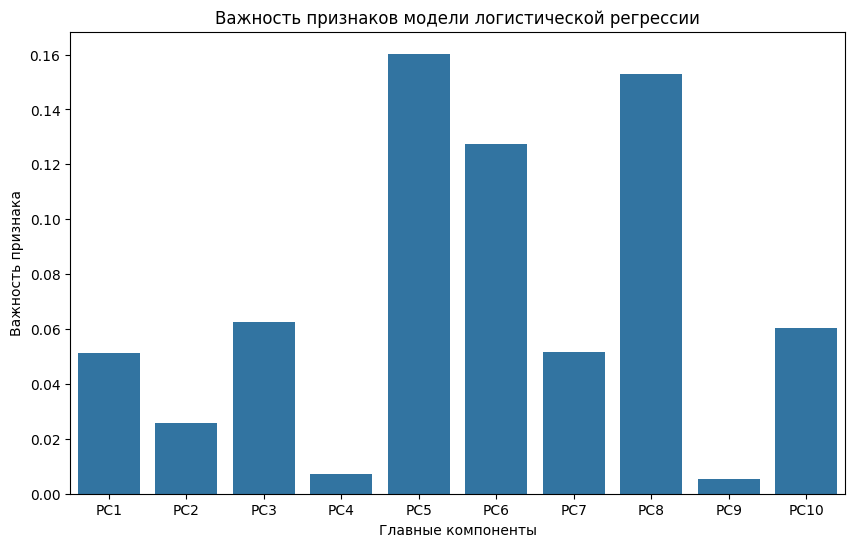

In [ ]:
# Установка необходимых библиотек
!pip install scanpy anndata

# Импорт библиотек
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Освобождение памяти перед началом работы
gc.collect()

# Загрузка данных
adata = sc.read_h5ad('/content/covid19_dataset/combat_processed.h5ad')

# Предобработка данных
# Нормализация общей считываемости и логарифмирование
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Сокращение числа генов до 100 наиболее вариабельных
sc.pp.highly_variable_genes(adata, n_top_genes=100)
adata = adata[:, adata.var.highly_variable]

# Выполнение PCA с 10 компонентами для снижения размерности
sc.tl.pca(adata, n_comps=10)
X_pca = adata.obsm['X_pca']

# Выбор целевой переменной
# Используем колонку 'disease' из аннотаций наблюдений
y = adata.obs['DiseaseClassification']
y = pd.Categorical(y).codes  # Преобразуем категории в числовые коды

# Освобождение памяти, удаляя исходный объект adata
del adata
gc.collect()

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Освобождение памяти, удаляя немасштабированные данные
del X_train, X_test, X_pca
gc.collect()

# Обучение модели логистической регрессии
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Предсказание на тестовых данных
y_pred = clf.predict(X_test_scaled)

# Оценка модели
test_acc = accuracy_score(y_test, y_pred)
print(f'Точность на тестовых данных: {test_acc:.4f}')

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

# Отчет классификации
print('Отчет классификации:')
print(classification_report(y_test, y_pred))

# Построение графика важности признаков
# Для логистической регрессии важность признаков можно получить из коэффициентов
feature_importance = np.abs(clf.coef_[0])
feature_names = [f'PC{i+1}' for i in range(len(feature_importance))]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=feature_importance)
plt.xlabel('Главные компоненты')
plt.ylabel('Важность признака')
plt.title('Важность признаков модели логистической регрессии')
plt.show()

In [ ]:
# Установка необходимых библиотек
!pip install scanpy anndata imbalanced-learn xgboost

# Импорт библиотек
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

# Освобождение памяти перед началом работы
gc.collect()

# Загрузка данных
adata = sc.read_h5ad('/content/covid19_dataset/combat_processed.h5ad')

# Предобработка данных
# Нормализация общей считываемости и логарифмирование
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Сокращение числа генов до 1000 наиболее вариабельных
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
adata = adata[:, adata.var.highly_variable]

# Выполнение PCA с 50 компонентами для снижения размерности
sc.tl.pca(adata, n_comps=50)
X_pca = adata.obsm['X_pca']

# Выбор целевой переменной
# Используем колонку 'DiseaseClassification' из аннотаций наблюдений
y = adata.obs['DiseaseClassification']
y = pd.Categorical(y).codes  # Преобразуем категории в числовые коды

# Освобождение памяти, удаляя исходный объект adata
del adata
gc.collect()

# Разделение данных на обучающую и тестовую выборки с стратификацией
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Освобождение памяти, удаляя немасштабированные данные
del X_train, X_test, X_pca
gc.collect()

# Балансировка данных с помощью комбинации SMOTE и Undersampling
# Сначала уменьшим доминирующий класс
rus = RandomUnderSampler(sampling_strategy={0: 50000}, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

# Затем увеличим меньшинствующие классы с помощью SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

# Проверка распределения классов после балансировки
print('Распределение классов после балансировки:', Counter(y_train_resampled))

# Настройка гиперпараметров Random Forest с помощью Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'class_weight': ['balanced', 'balanced_subsample']
}

clf_rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Лучшая модель
best_clf = grid_search.best_estimator_
print('Лучшие параметры модели:', grid_search.best_params_)

# Предсказание на тестовых данных
y_pred = best_clf.predict(X_test_scaled)

# Оценка модели
test_acc = accuracy_score(y_test, y_pred)
print(f'Точность на тестовых данных: {test_acc:.4f}')

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

# Отчет классификации
print('Отчет классификации:')
print(classification_report(y_test, y_pred))

# Построение графика важности признаков
importances = best_clf.feature

In [ ]:
# Установка необходимых библиотек
!pip install scanpy anndata imbalanced-learn xgboost

# Импорт библиотек
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

# Освобождение памяти перед началом работы
gc.collect()

# Загрузка данных
adata = sc.read_h5ad('/content/covid19_dataset/combat_processed.h5ad')

# Предобработка данных
# Нормализация общей считываемости и логарифмирование
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Сокращение числа генов до 1000 наиболее вариабельных
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
adata = adata[:, adata.var.highly_variable]

# Выполнение PCA с 50 компонентами для снижения размерности
sc.tl.pca(adata, n_comps=50)
X_pca = adata.obsm['X_pca']

# Выбор целевой переменной
# Используем колонку 'DiseaseClassification' из аннотаций наблюдений
y = adata.obs['DiseaseClassification']
y = pd.Categorical(y).codes  # Преобразуем категории в числовые коды

# Освобождение памяти, удаляя исходный объект adata
del adata
gc.collect()

# Разделение данных на обучающую и тестовую выборки с стратификацией
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Освобождение памяти, удаляя немасштабированные данные
del X_train, X_test, X_pca
gc.collect()

# Балансировка данных с помощью комбинации SMOTE и Undersampling
# Сначала уменьшим доминирующий класс
rus = RandomUnderSampler(sampling_strategy={0: 50000}, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

# Затем увеличим меньшинствующие классы с помощью SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

# Проверка распределения классов после балансировки
print('Распределение классов после балансировки:', Counter(y_train_resampled))

# Настройка гиперпараметров Random Forest с помощью Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'class_weight': ['balanced', 'balanced_subsample']
}

clf_rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Лучшая модель
best_clf = grid_search.best_estimator_
print('Лучшие параметры модели:', grid_search.best_params_)

# Предсказание на тестовых данных
y_pred = best_clf.predict(X_test_scaled)

# Оценка модели
test_acc = accuracy_score(y_test, y_pred)
print(f'Точность на тестовых данных: {test_acc:.4f}')

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

# Отчет классификации
print('Отчет классификации:')
print(classification_report(y_test, y_pred))

# Построение графика важности признаков
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = [f'PC{i+1}' for i in range(X_train_scaled.shape[1])]

plt.figure(figsize=(12, 6))
sns.barplot(x=[feature_names[i] for i in indices], y=importances[indices])
plt.xlabel('Главные компоненты')
plt.ylabel('Важность признака')
plt.title('Важность признаков модели Random Forest')
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Распределение классов после балансировки: Counter({0: 122874, 1: 122874, 2: 122874, 3: 122874})
